# Quora Duplicate Questions

Sam Weinberg (sam.weinberg@mail.utoronto.ca)

05/2021

This notebook outlines an NLP techniques for predicting whether or not two questions have the same intent. The Quora duplicate questions dataset was used, containing over 400k question pairs and a binary value indicating if the questions are essentially the same. For more information, check out the public dataset on Kaggle (https://www.kaggle.com/c/quora-question-pairs).

The goal of this notebook is to outline the following processes: cleaning textual data, filtering noise, feature engineering, predicting duplicate questions, and topic modelling. A large emphasis will be on feature engineering where we'll develop a feature set using various NLP techniques. Most of the duplicate prediciton features are derived from Abhishek's notebook (https://github.com/abhi1thakur/is_that_a_duplicate_quora_question).

## Python Libraries

In [247]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from fuzzywuzzy import fuzz

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, auc, roc_curve, log_loss, accuracy_score
from sklearn.preprocessing import StandardScaler

import gensim
#from gensim import models
from gensim.models import word2vec
from gensim.test.utils import common_texts
from gensim import corpora
from gensim.corpora.dictionary import Dictionary

import pyLDAvis
pyLDAvis.enable_notebook()

from scipy.spatial.distance import cosine
from scipy import sparse

from pprint import pprint
from IPython.display import display, HTML

import warnings
import tqdm

warnings.filterwarnings('ignore')

## Data Exploration and Basic Features

I'll start by loading in the dataset, exploring the data and extracting some basic features from the questions.

In [248]:
df = pd.read_csv('train.csv')

In [249]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


Some examples of non-duplicate questions.

In [250]:
df[df['is_duplicate'] == 0][['question1', 'question2', 'is_duplicate']]

,question1,question2,is_duplicate
0,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0
...,...,...,...
404283,What do you think of the removal of the MagSafe connector from Apple's 2016 MacBook Pro?,What will the CPU upgrade to the 2016 Apple MacBook Pro mean?,0
404285,How many keywords are there in the Racket programming language of the latest version?,How many keywords are there in PERL Programming Language in the latest version?,0
404287,What is one coin?,What's this coin?,0
404288,"What is the approx annual cost of living while studying in UIC Chicago, for an Indian student?","I am having little hairfall problem but I want to use hair styling product. Which one should I prefer out of gel, wax and clay?",0


Some examples of duplicate questions.

In [251]:
df[df['is_duplicate'] == 1][['question1', 'question2', 'is_duplicate']]

,question1,question2,is_duplicate
5,Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?,"I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?",1
7,How can I be a good geologist?,What should I do to be a great geologist?,1
11,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,What was your first sexual experience like?,What was your first sexual experience?,1
...,...,...,...
404280,What are some outfit ideas to wear to a frat party?,What are some outfit ideas wear to a frat themed party?,1
404281,Why is Manaphy childish in Pokémon Ranger and the Temple of the Sea?,Why is Manaphy annoying in Pokemon ranger and the temple of the sea?,1
404282,How does a long distance relationship work?,How are long distance relationships maintained?,1
404284,What does Jainism say about homosexuality?,What does Jainism say about Gays and Homosexuality?,1


Total number of questions and percetnage of positive samples.

In [252]:
print("Total number of question pairs: {}".format(len(df)))
print("Total number of duplicate questions: {}".format(len(df[df.is_duplicate == 1])))
print("Percentage of question pairs that are duplicates: {} %".format(np.round(100*len(df[df.is_duplicate == 1])/len(df), 2)))

Total number of question pairs: 404290
Total number of duplicate questions: 149263
Percentage of question pairs that are duplicates: 36.92 %


Function to extract basic features from questions (i.e. length in chars/words, difference in length, num shared words).

In [253]:
def get_fs_1(df):

    # Calculate lengths of question in chars
    df['q1_len_char'] = df.apply(lambda row: len(str(row['question1'])), axis = 1)
    df['q2_len_char'] = df.apply(lambda row: len(str(row['question2'])), axis = 1)

    # Calculate lengths of question in words
    df['q1_len_words'] = df.apply(lambda row: len(str(row['question1']).split(' ')), axis = 1)
    df['q2_len_words'] = df.apply(lambda row: len(str(row['question2']).split(' ')), axis = 1)

    # Calculate number of common words in each question pair
    df['num_common_words'] = df.apply(lambda row: len([word for word in str(row['question1']).lower().split(' ') if word in str(row['question2']).lower().split(' ')]), axis = 1)
    
    # Calculate q1 and q2 percentage common words of total words
    df['q1_pct_common_words'] = df.apply(lambda row: row['num_common_words']/row['q1_len_words'], axis = 1)
    df['q2_pct_common_words'] = df.apply(lambda row: row['num_common_words']/row['q2_len_words'], axis = 1)
    
    # Calculate char difference and word difference
    df['char_dif'] = np.abs(df['q1_len_char'] - df['q2_len_char'])
    df['word_dif'] = np.abs(df['q1_len_words'] - df['q2_len_words'])

    return df



Apply function and plot question length distributions.

(array([3.63265000e-03, 3.09498426e-02, 1.29509318e-01, 8.78575163e-02,
        5.34248993e-02, 4.84496571e-02, 1.89608399e-02, 1.30727188e-02,
        1.30129782e-02, 6.48552746e-03, 6.03694864e-03, 5.72147615e-03,
        1.78802680e-03, 1.39604437e-03, 7.23176139e-04, 6.64483583e-04,
        5.89021725e-04, 1.62452611e-04, 1.70837262e-04, 2.07520110e-04,
        1.32058252e-04, 1.34154414e-04, 1.76077669e-04, 1.34154414e-04,
        9.32792412e-05, 1.05856217e-04, 3.87790104e-05, 2.51539527e-05,
        6.28848817e-06, 6.28848817e-06, 6.28848817e-06, 6.28848817e-06,
        3.14424408e-06, 3.14424408e-06, 1.04808136e-06, 1.04808136e-06,
        1.04808136e-06, 2.09616272e-06, 3.14424408e-06, 1.04808136e-06,
        1.04808136e-06, 0.00000000e+00, 0.00000000e+00, 1.04808136e-06,
        2.09616272e-06, 2.09616272e-06, 1.04808136e-06, 2.09616272e-06,
        0.00000000e+00, 1.04808136e-06, 0.00000000e+00, 0.00000000e+00,
        1.04808136e-06, 2.09616272e-06, 0.00000000e+00, 0.000000

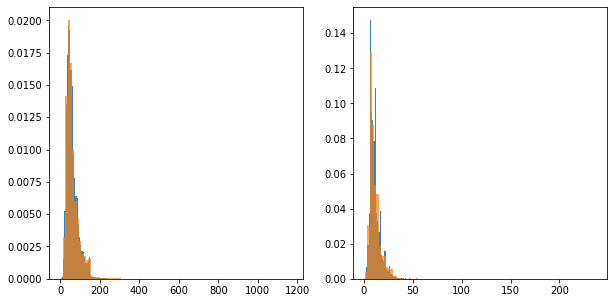

In [254]:
# Get basic features
df = get_fs_1(df)

# Histogram of number of words and chars
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
ax1.hist(df['q1_len_char'], bins=100, density = True, alpha=0.9)
ax1.hist(df['q2_len_char'], bins=100, density = True, alpha=0.7)
ax2.hist(df['q1_len_words'], bins=100, density = True, alpha=0.9)
ax2.hist(df['q2_len_words'], bins=100, density = True, alpha=0.7)

Looking at histograms and descriptive statistics, it appears there are some noisy samples. Let's remove questions with more than 150 characters, and remove questions with less than 10 characters or 3 words.

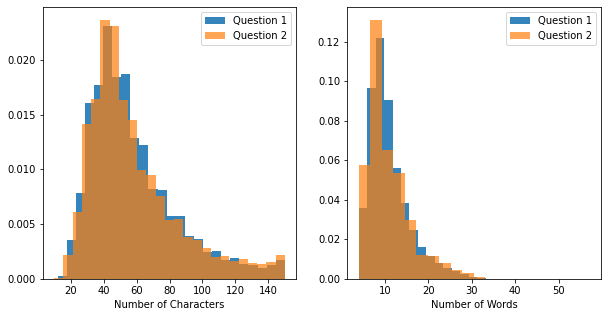

In [255]:
# Dropping noisy samples
df.drop(df.loc[df['q1_len_char'] > 150].index, axis = 0, inplace = True)
df.drop(df.loc[(df['q1_len_char'] < 10) | (df['q1_len_words'] < 4)].index, axis = 0, inplace = True)

df.drop(df.loc[df['q2_len_char'] > 150].index, axis = 0, inplace = True)
df.drop(df.loc[(df['q2_len_char'] < 10) | (df['q2_len_words'] < 4)].index, axis = 0, inplace = True)

# Reset indeces
df = df.reset_index(drop=True)

# Histogram of number of words and chars after filtering
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
ax1.hist(df['q1_len_char'], bins = 25, density = True, alpha = 0.9)
ax1.hist(df['q2_len_char'], bins = 25, density = True, alpha = 0.7)
ax2.hist(df['q1_len_words'], bins = 20, density = True, alpha = 0.9)
ax2.hist(df['q2_len_words'], bins = 20, density = True, alpha = 0.7)

ax1.set_xlabel('Number of Characters')
ax1.legend(labels = ('Question 1', 'Question 2'))
ax2.set_xlabel('Number of Words')
ax2.legend(labels = ('Question 1', 'Question 2'))


In [256]:
print("Total number of question pairs: {}".format(len(df)))
print("Total number of duplicate questions: {}".format(len(df[df.is_duplicate == 1])))
print("Percentage of question pairs that are duplicates: {} %".format(np.round(100*len(df[df.is_duplicate == 1])/len(df), 2)))

Total number of question pairs: 388970
Total number of duplicate questions: 147438
Percentage of question pairs that are duplicates: 37.9 %


In [257]:
# Descriptive statistics for basic features
df.describe()

,id,qid1,qid2,is_duplicate,q1_len_char,q2_len_char,q1_len_words,q2_len_words,num_common_words,q1_pct_common_words,q2_pct_common_words,char_dif,word_dif
count,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000,388970.000000
mean,202159.729079,216158.714150,219593.688128,0.379047,58.328033,58.225128,10.728511,10.836854,4.768823,0.468401,0.471276,18.245435,3.342577
std,116697.571265,157754.369097,159875.396492,0.485151,26.544524,27.621270,4.770726,5.060747,3.373053,0.264811,0.274499,20.158377,3.806405
min,0.000000,1.000000,2.000000,0.000000,12.000000,10.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,101131.250000,73421.250000,73458.000000,0.000000,39.000000,39.000000,7.000000,7.000000,3.000000,0.250000,0.250000,4.000000,1.000000
50%,202158.500000,190535.000000,194922.000000,0.000000,52.000000,51.000000,10.000000,9.000000,4.000000,0.454545,0.454545,11.000000,2.000000
75%,303228.750000,345196.500000,352968.250000,1.000000,71.000000,70.000000,13.000000,13.000000,6.000000,0.666667,0.666667,24.000000,4.000000
max,404289.000000,537932.000000,537933.000000,1.000000,150.000000,150.000000,43.000000,57.000000,35.000000,1.000000,2.444444,133.000000,41.000000


Histogram of number of common words split by label. Predictive power of basic features is very limited.

(-1.0, 25.0)

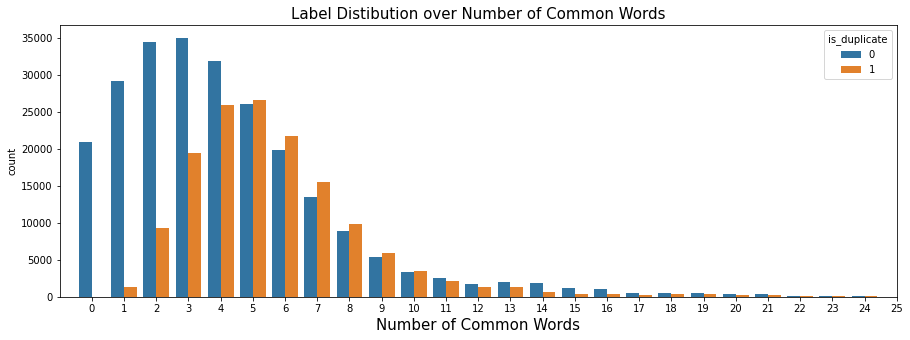

In [358]:
# Label distribution over number of common words
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(x = 'num_common_words', data = df, hue = 'is_duplicate')
ax.set_title('Label Distibution over Number of Common Words', fontsize=15)
ax.set_xlabel('Number of Common Words', fontsize=15)
ax.set_xlim([-1, 25])

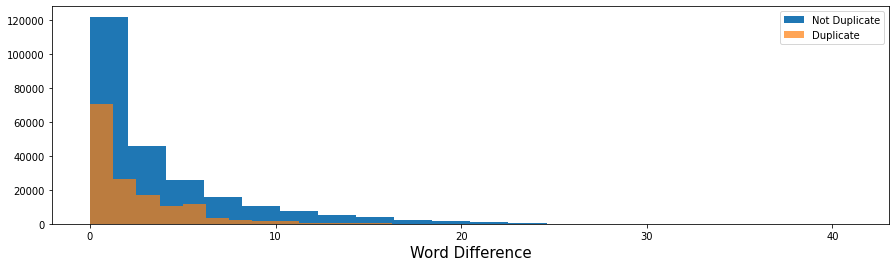

In [361]:
plt.figure(figsize=(15, 4))
plt.hist(df[df['is_duplicate'] == 0]['word_dif'], bins = 20, label = 'Not Duplicate')
plt.hist(df[df['is_duplicate'] == 1]['word_dif'], bins = 20, alpha = 0.7, label = 'Duplicate')
plt.xlabel('Word Difference', fontsize=15)
plt.legend()

Here's a histogram of shared word perecntage.

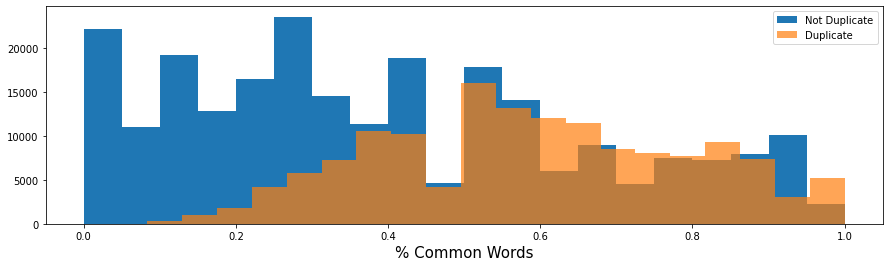

In [259]:
plt.figure(figsize=(15, 4))
plt.hist(df[df['is_duplicate'] == 0]['q1_pct_common_words'], bins = 20, label = 'Not Duplicate')
plt.hist(df[df['is_duplicate'] == 1]['q1_pct_common_words'], bins = 20, alpha = 0.7, label = 'Duplicate')
plt.xlabel('% Common Words', fontsize=15)
plt.legend()

Example of questions that dont share any common words.

In [260]:
df[df.num_common_words == 0][['question1', 'question2', 'is_duplicate']]

,question1,question2,is_duplicate
3,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
6,Should I buy tiago?,What keeps childern active and far from phone and video games?,0
23,How much is 30 kV in HP?,Where can I find a conversion chart for CC to horsepower?,0
24,What does it mean that every time I look at the clock the numbers are the same?,How many times a day do a clock’s hands overlap?,0
27,Does society place too much importance on sports?,How do sports contribute to the society?,0
...,...,...,...
388874,"Are there DIY packaging/shipping places in Columbus, Ohio?","Do dogs understand if you have to hurt them, like when treating a wound?",0
388875,What is the midbrain activation technique?,Why does our brain make us assume we are always right even though we know we are not?,0
388899,What is Holi for?,What's the holiness of God?,0
388921,What are the reviews of SensoVision System?,Is Lothar Matthaus Germany's greatest footballer?,0


Example of duplicates that share 1 common word.

In [261]:
df[(df.num_common_words == 1) & (df.is_duplicate == 1)][['question1', 'question2', 'is_duplicate']]

,question1,question2,is_duplicate
213,What is my puk code?,What's the PUK for TF64SIMC4?,1
324,What would be the best way to quit smoking?,How did you quit/stop smoking?,1
384,How can I get entry in MIT?,What are the requirements for selection into MIT?,1
423,What are the minimum requirements to enter MIT?,How can I join MIT?,1
472,How should I study,What are some tricks to study effectively?,1
...,...,...,...
388064,Can we time travel?,Time Travel Is It Possible?,1
388401,Can we manipulate space time?,How does one manipulate space-time?,1
388590,What's the future of biotechnology?,What is scope in biotechnology?,1
388870,Which fruit contains fat?,What fruits contain fat?,1


Example of non-duplicates that share 20 common words.

In [262]:
df[(df.num_common_words >= 20) & (df.is_duplicate == 0)][['question1', 'question2', 'is_duplicate']]

,question1,question2,is_duplicate
14,"What are the laws to change your status from a student visa to a green card in the US, how do they compare to the immigration laws in Canada?",What are the laws to change your status from a student visa to a green card in the US? How do they compare to the immigration laws in Japan?,0
407,"How can the drive from Brooklyn to Staten Island be described, and how do these cities' tourist attractions compare to those in Queens?","How can the drive from Brooklyn to Staten Island be described, and how do these cities' tourist attractions compare to other tourist attractions?",0
1002,"What hotel in Shimla Hill-station would be safe for unmarried couples, without the harassment of police, hotel staff, and moral police?","What hotel in Dehradun Hill-station would be safe for unmarried couples, without the harassment of police, hotel staff, and moral police?",0
1321,What are good gifts for a foreign visitor to bring when they're invited to someone's home in Martinique for the first time?,What are good gifts for a foreign visitor to bring when they're invited to someone's home in Pakistan for the first time?,0
1411,What is the best place to visit in the world? What is the best place to visit in India? What is the best place to visit in Bihar?,What is the best place in India to visit?,0
...,...,...,...
387493,What are good gifts for a foreign visitor to bring when they're invited to someone's home in Tajikistan for the first time?,What are good gifts for a foreign visitor to bring when they're invited to someone's home in Pakistan for the first time?,0
387955,"What hotel in Srinagar Hill-station would be safe for unmarried couples, without the harassment of police, hotel staff, and moral police?","What hotel in Pahalgam Hill-station would be safe for unmarried couples, without the harassment of police, hotel staff, and moral police?",0
388422,Only 3 in 10 view Hillary Clinton as honest. How did this happen? How will it impact the 2016 Presidential election?,Only 3 in 10 view Hillary Clinton as compassionate. How did this happen? How will it impact the 2016 Presidential election?,0
388486,"What hotel in Darjeeling Hill-station would be safe for unmarried couples, without the harassment of police, hotel staff, and moral police?","What hotel in Wayanad Hill-station would be safe for unmarried couples, without the harassment of police, hotel staff, and moral police?",0


## Text Processing and Feature Engineering
Now I'll go through some core NLP feature engineering techniques. We'll compare the features we generate to some sample questions to better understand their predictive ability.

### Approximate String Matching
Approximate string matching uss Levenshtein distance to compute metrics for string similarity. The Levenshtein distance is the number of single character edits required to change one string to another. SeatGeek has developed a library called Fuzzywuzzy which can easily be applied to textual data. For more information on the metrics, check out this blog post: https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

Function that applies several metrics from the fuzzywuzzy library to the entire dataset. These metrics can take a long time to compute, so their usage in a production setting may be limited.

In [263]:
def get_fs_2(df):

    # Compute Levenshtein metrics
    df['fuzz_ratio'] = df.apply(lambda row: fuzz.ratio(str(row['question1']), str(row['question2'])), axis = 1)
    df['fuzz_partial_ratio'] = df.apply(lambda row: fuzz.partial_ratio(str(row['question1']), str(row['question2'])), axis = 1)
    df['fuzz_token_set_ratio'] = df.apply(lambda row: fuzz.token_set_ratio(str(row['question1']), str(row['question2'])), axis = 1)
    df['fuzz_token_sort_ratio'] = df.apply(lambda row: fuzz.token_sort_ratio(str(row['question1']), str(row['question2'])), axis = 1)
    df['fuzz_partial_token_set_ratio'] = df.apply(lambda row: fuzz.partial_token_set_ratio(str(row['question1']), str(row['question2'])), axis = 1)
    df['fuzz_partial_token_sort_ratio'] = df.apply(lambda row: fuzz.partial_token_sort_ratio(str(row['question1']), str(row['question2'])), axis = 1)

    return df




Apply the function to our data and visualize distibution of features, split by duplicate label.

In [264]:
df = get_fs_2(df)

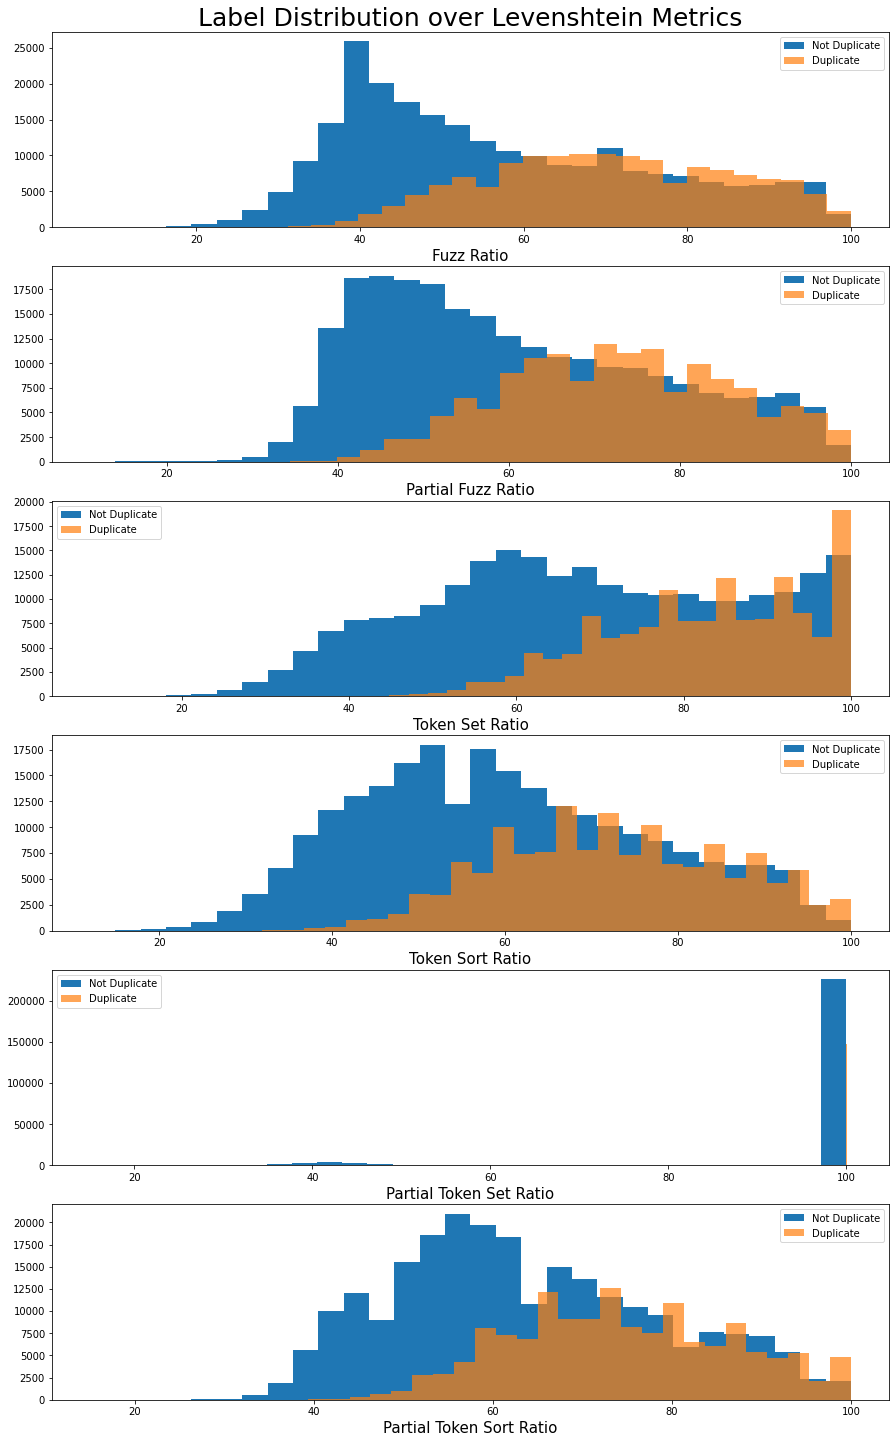

In [265]:
# Label distribution over fuzzy features
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(15, 20))

ax1.hist(df[df['is_duplicate'] == 0]['fuzz_ratio'], bins = 30, label = 'Not Duplicate')
ax1.hist(df[df['is_duplicate'] == 1]['fuzz_ratio'], bins = 30, alpha = 0.7, label = 'Duplicate')
ax1.set_xlabel('Fuzz Ratio', fontsize=15)
ax1.legend()

ax2.hist(df[df['is_duplicate'] == 0]['fuzz_partial_ratio'], bins = 30, label = 'Not Duplicate')
ax2.hist(df[df['is_duplicate'] == 1]['fuzz_partial_ratio'], bins = 30, alpha = 0.7, label = 'Duplicate')
ax2.set_xlabel('Partial Fuzz Ratio', fontsize=15)
ax2.legend()

ax3.hist(df[df['is_duplicate'] == 0]['fuzz_token_set_ratio'], bins = 30, label = 'Not Duplicate')
ax3.hist(df[df['is_duplicate'] == 1]['fuzz_token_set_ratio'], bins = 30, alpha = 0.7, label = 'Duplicate')
ax3.set_xlabel('Token Set Ratio', fontsize=15)
ax3.legend()

ax4.hist(df[df['is_duplicate'] == 0]['fuzz_token_sort_ratio'], bins = 30, label = 'Not Duplicate')
ax4.hist(df[df['is_duplicate'] == 1]['fuzz_token_sort_ratio'], bins = 30, alpha = 0.7, label = 'Duplicate')
ax4.set_xlabel('Token Sort Ratio', fontsize=15)
ax4.legend()

ax5.hist(df[df['is_duplicate'] == 0]['fuzz_partial_token_set_ratio'], bins = 30, label = 'Not Duplicate')
ax5.hist(df[df['is_duplicate'] == 1]['fuzz_partial_token_set_ratio'], bins = 30, alpha = 0.7, label = 'Duplicate')
ax5.set_xlabel('Partial Token Set Ratio', fontsize=15)
ax5.legend()

ax6.hist(df[df['is_duplicate'] == 0]['fuzz_partial_token_sort_ratio'], bins = 30, label = 'Not Duplicate')
ax6.hist(df[df['is_duplicate'] == 1]['fuzz_partial_token_sort_ratio'], bins = 30, alpha = 0.7, label = 'Duplicate')
ax6.set_xlabel('Partial Token Sort Ratio', fontsize=15)
ax6.legend()

ax1.set_title('Label Distribution over Levenshtein Metrics', fontsize=25)
plt.subplots_adjust(top=1, bottom=0.05, hspace=0.2)




Example of Fuzz Ratios greater than 90 that aren't duplicates. Most questions differ by one word.

In [364]:
df[(df.fuzz_ratio > 90) & (df.is_duplicate == 0)][['question1', 'question2', 'fuzz_ratio', 'fuzz_partial_ratio', 'is_duplicate']]

,question1,question2,fuzz_ratio,fuzz_partial_ratio,is_duplicate
0,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,93,98,0
14,"What are the laws to change your status from a student visa to a green card in the US, how do they compare to the immigration laws in Canada?",What are the laws to change your status from a student visa to a green card in the US? How do they compare to the immigration laws in Japan?,96,96,0
25,What are some tips on making it through the job interview process at Medicines?,What are some tips on making it through the job interview process at Foundation Medicine?,93,91,0
28,What is best way to make money online?,What is best way to ask for money online?,91,87,0
40,When can I expect my Cognizant confirmation mail?,When can I expect Cognizant confirmation mail?,97,93,0
...,...,...,...,...,...
388868,What are some different ways of doing seated rows? What are the benefits and tradeoffs of each?,What are some different ways of doing cable rows? What are the benefits and tradeoffs of each?,96,96,0
388872,Which is the best deal website for online shopping?,Which is the best deals site for online shopping?,96,94,0
388879,How do the tourist attractions on the Scandinavian Highlands compare to attractions in Switzerland?,How do the tourist attractions on the Scandinavian Highlands compare to attractions in Hungary?,92,93,0
388888,Which professors from IIT Guwahati would you love to see on Quora?,Which Professors from IIT Delhi would you love to see on Quora?,91,89,0


### TF-IDF
Compute term frequency - inverse document frequency to weight words by their relative importance. Before we get the TF-IDF, we need to clean the textual data. This means removing non-alphabetic characters, replacing contractions, removing punctation, removing stopwords, and making everything lowercase. This will ensure that the term matrix doesn't conatin multiple columns for words or phrases with the same intention. 

In [266]:
# Clean and filter questions
# Cleaning function from lystdo's notebook (https://www.kaggle.com/lystdo/lstm-with-word2vec-embeddings)

# Define tokenizer, stemmer, and stop words
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


# Function to apply to df rows
def clean_qs(text, lemmatize = False):
    
    # Tokenize words to remove stopwords, then join words
    text = tokenizer.tokenize(str(text))   
    text = [word.lower() for word in text if word.lower() not in stop_words]
    text = [word for word in text if word.isalpha()]
    text = " ".join(text)
    
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # I found that a number of the word stems were not contained within the google-news embeddings
    # Use stemmer
    if lemmatize:
        text = tokenizer.tokenize(str(text))   
        text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
        text = " ".join(text)
    
    return text


Apply cleaning function and view some examples of the cleaned version.

In [267]:
# Apply cleaning
df['q1_clean'] = df.question1.apply(clean_qs)
df['q2_clean'] = df.question2.apply(clean_qs)


In [268]:
# Apply lemmatized cleaning
df['q1_lemma'] = df.question1.apply(clean_qs, lemmatize = True)
df['q2_lemma'] = df.question2.apply(clean_qs, lemmatize = True)

In [269]:
df[['question1', 'q1_clean', 'q1_lemma', 'question2', 'q2_clean', 'q2_lemma']]

,question1,q1_clean,q1_lemma,question2,q2_clean,q2_lemma
0,What is the step by step guide to invest in share market in india?,step step guide invest share market india,step step guide invest share market india,What is the step by step guide to invest in share market?,step step guide invest share market,step step guide invest share market
1,What is the story of Kohinoor (Koh-i-Noor) Diamond?,story kohinoor koh noor diamond,story kohinoor koh noor diamond,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,would happen indian government stole kohinoor koh noor diamond back,would happen indian government stole kohinoor koh noor diamond back
2,How can I increase the speed of my internet connection while using a VPN?,increase speed internet connection using vpn,increase speed internet connection using vpn,How can Internet speed be increased by hacking through DNS?,internet speed increased hacking dns,internet speed increased hacking dns
3,Why am I mentally very lonely? How can I solve it?,mentally lonely solve,mentally lonely solve,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",find remainder math math divided,find remainder math math divided
4,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",one dissolve water quikly sugar salt methane carbon di oxide,one dissolve water quikly sugar salt methane carbon di oxide,Which fish would survive in salt water?,fish would survive salt water,fish would survive salt water
...,...,...,...,...,...,...
388965,What does Jainism say about homosexuality?,jainism say homosexuality,jainism say homosexuality,What does Jainism say about Gays and Homosexuality?,jainism say gays homosexuality,jainism say gay homosexuality
388966,How many keywords are there in the Racket programming language of the latest version?,many keywords racket programming language latest version,many keywords racket programming language latest version,How many keywords are there in PERL Programming Language in the latest version?,many keywords perl programming language latest version,many keywords perl programming language latest version
388967,Do you believe there is life after death?,believe life death,believe life death,Is it true that there is life after death?,true life death,true life death
388968,"What is the approx annual cost of living while studying in UIC Chicago, for an Indian student?",approx annual cost living studying uic chicago indian student,approx annual cost living studying uic chicago indian student,"I am having little hairfall problem but I want to use hair styling product. Which one should I prefer out of gel, wax and clay?",little hairfall problem want use hair styling product one prefer gel wax clay,little hairfall problem want use hair styling product one prefer gel wax clay


Let's look at some instances where the cleaning gets us in trouble. Here we have questions that are identical after cleaning, but are not duplicates.

In [270]:
df.loc[(df['q1_clean'] == df['q2_clean']) & (df['is_duplicate'] == 0)][['question1', 'question2', 'q1_clean', 'is_duplicate']].head(30)

,question1,question2,q1_clean,is_duplicate
40,When can I expect my Cognizant confirmation mail?,When can I expect Cognizant confirmation mail?,expect cognizant confirmation mail,0
41,"Can I make 50,000 a month by day trading?","Can I make 30,000 a month by day trading?",make month day trading,0
88,What is your review of The Next Warrior: Proving Grounds - Part 9?,What is your review of The Next Warrior: Proving Grounds - Part 5?,review next warrior proving grounds part,0
108,Is USA the most powerful country of the world?,Why is the USA the most powerful country of the world?,usa powerful country world,0
214,How can I find job in Japan?,How can I find an IT job in Japan?,find job japan,0
266,How do most people die?,How do people die?,people die,0
286,On what online platforms can I post ads for beer money opportunity?,What online platforms can I post ads for beer money opportunity?,online platforms post ads beer money opportunity,0
290,Do you need friends?,Why do we need friends?,need friends,0
306,Why should I learn web design?,How can I learn about web design?,learn web design,0
371,How do scientists work?,Where do scientists work?,scientists work,0


In [271]:
# Create TF-IDF matrix
tfidf_q1 = TfidfVectorizer(min_df=3, 
                        max_features=None, 
                        strip_accents='unicode', 
                        analyzer='word', 
                        ngram_range=(1, 2), 
                        use_idf=1, 
                        smooth_idf=1, 
                        sublinear_tf=1)

tfidf_q2 = TfidfVectorizer(min_df=3, 
                        max_features=None, 
                        strip_accents='unicode', 
                        analyzer='word', 
                        ngram_range=(1, 2), 
                        use_idf=1, 
                        smooth_idf=1, 
                        sublinear_tf=1)


Xq1 = tfidf_q1.fit_transform(df['q1_clean'])
Xq2 = tfidf_q2.fit_transform(df['q2_clean'])


## Topic Modelling
I'll now look at some common topic modelling technicques: LSA and LDA.

### Latent Semantic Analysis
Input our tf-idf features to LSA, produces latent 'topics' which can be used as features for prediction or as an interesting output to find similar questions.

In [272]:
# LSA features for both questions
lsa_q1 = TruncatedSVD(n_components=20)
X_svd_q1 = lsa_q1.fit_transform(Xq1)

lsa_q2 = TruncatedSVD(n_components=20)
X_svd_q2 = lsa_q2.fit_transform(Xq1)

In [273]:
# View top 10 words in each topics
terms = tfidf_q1.get_feature_names()
for i, comp in enumerate(lsa_q1.components_):
    termsInComp = zip(terms, comp)
    sortedTerms = sorted(termsInComp, key = lambda x: x[1], reverse = True)[:10]
    print('Concept {}'.format(i))
    for term in sortedTerms:
        print(term[0])
    print('\n')


Concept 0
best
way
best way
money
make
learn
online
make money
get
india


Concept 1
money
make
make money
online
money online
earn
earn money
quora
way make
much


Concept 2
get
quora
people
trump
like
donald
donald trump
know
questions
would


Concept 3
trump
donald
donald trump
clinton
hillary
hillary clinton
win
president
trump win
election


Concept 4
know
new
things
first
day
first day
going
know going
new employees
things new


Concept 5
get
weight
lose
lose weight
rid
get rid
good
ways
job
ways lose


Concept 6
weight
lose
lose weight
quora
people
questions
questions quora
question
ask
ways lose


Concept 7
difference
like
life
india
good
love
language
english
programming
work


Concept 8
like
life
feel
feel like
work
india
good
would
meaning
purpose


Concept 9
english
improve
learn
improve english
way
best way
language
programming
skills
way learn


Concept 10
life
good
meaning
purpose
purpose life
thing
meaning life
one
important
improve


Concept 11
india
english
improve
im

### Latent Dirichlet Allocation
This is the most popular technique for topic modelling. I'll implement it using gensim and sklearn to see which gives better topics.

### LDA: Gensim Implemenatation
I found the Gensim implementation didn't produce coherent topics, so I switched over to the sklearn API.

In [26]:
# Build a corpus for gensim model
texts = df['q1_clean'].to_list() + df['q2_clean'].to_list()
texts = [tokenizer.tokenize(str(sent)) for sent in texts]



In [27]:
# Make bigram model
bigram = gensim.models.Phrases(texts, min_count = 5, threshold = 100) 
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [28]:
# Build bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

texts = make_bigrams(texts)

[['step_step', 'guide', 'invest', 'share', 'market', 'india'],
 ['story', 'kohinoor_koh', 'noor_diamond'],
 ['increase', 'speed', 'internet', 'connection', 'using', 'vpn'],
 ['mentally', 'lonely', 'solve'],
 ['one',
  'dissolve',
  'water',
  'quikly',
  'sugar',
  'salt',
  'methane',
  'carbon',
  'di',
  'oxide'],
 ['astrology', 'capricorn', 'sun', 'cap', 'moon', 'cap', 'rising', 'say'],
 ['buy', 'tiago'],
 ['good', 'geologist'],
 ['use', 'instead'],
 ['motorola', 'company', 'hack', 'charter', 'motorolla'],
 ['method', 'find', 'separation', 'slits', 'using', 'fresnel', 'biprism'],
 ['read', 'find', 'youtube', 'comments'],
 ['make', 'physics', 'easy', 'learn'],
 ['first', 'sexual', 'experience', 'like'],
 ['laws',
  'change',
  'status',
  'student',
  'visa',
  'green',
  'card',
  'us',
  'compare',
  'immigration_laws',
  'canada'],
 ['would',
  'trump',
  'presidency',
  'mean',
  'current',
  'international',
  'master',
  'students',
  'visa'],
 ['manipulation', 'mean'],
 ['gir

In [29]:
# Build dictionary
ID2word = Dictionary(texts)

# Convert corpus to bag of words
train_corpus = [ID2word.doc2bow(doc) for doc in texts]

In [30]:
# Define coherence score function for evaluating hyperparamters
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=2)
    
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=ID2word, coherence='c_v')
    
    return lda_model, coherence_model_lda.get_coherence()

In [33]:
# Build LDA models for different numbers of topics and compute coherence scores
pbar = tqdm.tqdm(total=6)

topics = [5, 8, 11, 14, 17, 20]
cms = []
models = []

for k in topics:
    lda, cm = compute_coherence_values(train_corpus, ID2word, k)
    cms.append(cm)
    models.append(lda)
    pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [2:47:21<00:00, 1751.37s/it]

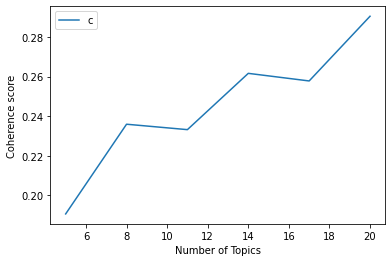

In [123]:
# Plot coherence scores
plt.plot(topics, cms)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Visualize LDA model for n = 11 topics.

In [39]:
gensimvis.prepare(models[2], train_corpus, ID2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.177212 -0.074837  1       1        10.043255
6     -0.150633 -0.014856  2       1        9.876000 
9     -0.201103  0.051541  3       1        9.348706 
5     -0.050094 -0.128984  4       1        9.233416 
2      0.182485  0.115596  5       1        9.200595 
1     -0.143737  0.020211  6       1        9.173320 
7      0.258676  0.035088  7       1        9.143598 
4     -0.127708  0.155109  8       1        8.719057 
3     -0.051368 -0.351288  9       1        8.602496 
8     -0.040173  0.207660  10      1        8.410126 
0      0.146443 -0.015241  11      1        8.249430 , topic_info=        Term          Freq         Total Category  logprob  loglift
96   best     81350.000000  81350.000000  Default  30.0000  30.0000
57   make     21570.000000  21570.000000  Default  29.0000  29.0000
125  way      21141.000000  21141.000000  Default  28.0000  28.0000
92   quora    20405.000000  20405.000000  Default  27.0000  27.0000
320  life     18671.000000  18671.000000  Default  26.0000  26.0000
..    ...              ...           ...      ...      ...      ...
258  without  2765.348445   10057.828072  Topic11 -4.7223   1.2038 
56   learn    2818.108038   14911.240404  Topic11 -4.7034   0.8290 
156  people   3248.294893   29267.951051  Topic11 -4.5613   0.2967 
22   one      2612.178768   21701.085486  Topic11 -4.7792   0.3778 
1    india    2452.855644   33508.134448  Topic11 -4.8422  -0.1195 

[477 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3616  10     0.999479  able    
318   2      0.215674  account 
318   3      0.510563  account 
318   9      0.273696  account 
2126  2      0.999532  actually
...  ..           ...      ... 
1119  3      0.999734  write   
1113  3      0.999494  x       
166   8      0.696167  year    
166   10     0.303762  year    
167   8      0.999729  years   

[571 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 7, 10, 6, 3, 2, 8, 5, 4, 9, 1])

### LDA: Sklearn Implementation
I stacked the questions on top of each other and made a new term frequency matrix to input into LDA.

In [161]:
# Stack questions
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df1['qs'] = df['q1_clean']
df2['qs'] = df['q2_clean']
df1['question'] = df['question1']
df2['question'] = df['question2']
df_stack = pd.concat([df1, df2])
df_stack = df_stack.reset_index(drop=True)
df_stack

,qs,question
0,step step guide invest share market india,What is the step by step guide to invest in share market in india?
1,story kohinoor koh noor diamond,What is the story of Kohinoor (Koh-i-Noor) Diamond?
2,increase speed internet connection using vpn,How can I increase the speed of my internet connection while using a VPN?
3,mentally lonely solve,Why am I mentally very lonely? How can I solve it?
4,one dissolve water quikly sugar salt methane carbon di oxide,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?"
...,...,...
777935,jainism say gays homosexuality,What does Jainism say about Gays and Homosexuality?
777936,many keywords perl programming language latest version,How many keywords are there in PERL Programming Language in the latest version?
777937,true life death,Is it true that there is life after death?
777938,little hairfall problem want use hair styling product one prefer gel wax clay,"I am having little hairfall problem but I want to use hair styling product. Which one should I prefer out of gel, wax and clay?"


In [44]:
# Build LDA model using sklearn
tf_vectorizer = CountVectorizer(ngram_range=(1,2), max_df=0.95, min_df=3, max_features=10000)

tf = tf_vectorizer.fit_transform(df_stack['qs'])

In [204]:
lda_sk = LatentDirichletAllocation(n_components = 11, topic_word_prior = 0.01, n_jobs = -1, verbose = 1, random_state = 0)
lda_sk.fit(tf)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=11, n_jobs=-1,
                          perp_tol=0.1, random_state=0, topic_word_prior=0.01,
                          total_samples=1000000.0, verbose=1)

Running for different topics can take a long time! Also watch your memory.

In [46]:
# Fit different numbers of topics
import joblib
models_sk = []

pbar = tqdm.tqdm(total=6)

for k in topics:
    lda_sk = LatentDirichletAllocation(n_components = k, n_jobs = -1)
    lda_sk.fit(tf)
    models_sk.append(lda_sk)
    pbar.update(1)

    



  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

 17%|█████████████▌                                                                   | 1/6 [13:03<1:05:17, 783.45s/it]

 33%|███████████████████████████▋                                                       | 2/6 [25:37<51:38, 774.74s/it]

 50%|█████████████████████████████████████████▌                                         | 3/6 [36:41<37:04, 741.45s/it]

 67%|███████████████████████████████████████████████████████▎                           | 4/6 [47:42<23:54, 717.13s/it]

 83%|█████████████████████████████████████████████████████████████████████▏             | 5/6 [58:39<11:39, 699.14s/it]

100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [1:09:02<00:00, 676.31s/it]

Save models using joblib

In [47]:
i = 0
for k in topics:
    joblib.dump(models_sk[i], 'lda_models/lda_sklearn/lda_sk_{}'.format(k))
    i+=1

Visualize different sklearn models

In [49]:
pyLDAvis.sklearn.prepare(models_sk[1], tf, tf_vectorizer)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.194216 -0.046090  1       1        14.954300
4      0.045868 -0.080089  2       1        13.188671
2     -0.175507  0.099647  3       1        12.770177
5     -0.220368 -0.134852  4       1        12.747470
0      0.095480  0.251557  5       1        12.710675
1      0.068507  0.166324  6       1        11.316092
7     -0.205261 -0.038601  7       1        11.257730
3      0.197064 -0.217897  8       1        11.054884, topic_info=           Term          Freq         Total Category  logprob  loglift
804   best       68781.000000  68781.000000  Default  30.0000  30.0000
3693  good       24372.000000  24372.000000  Default  29.0000  29.0000
6467  people     25008.000000  25008.000000  Default  28.0000  28.0000
4324  india      28621.000000  28621.000000  Default  27.0000  27.0000
5050  like       23829.000000  23829.000000  Default  26.0000  26.0000
...    ...                ...           ...      ...      ...      ...
2778  employees  1967.125568   2817.363511   Topic8  -5.4840   1.8431 
9867  would      3501.413499   21764.408758  Topic8  -4.9074   0.3752 
5025  life       2979.304465   15707.845356  Topic8  -5.0688   0.5398 
5952  new        2733.482133   12059.574335  Topic8  -5.1550   0.7180 
7282  really     2264.378498   6401.830356   Topic8  -5.3432   1.1630 

[532 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
40    2      0.001771  access  
40    5      0.998045  access  
48    5      0.836276  account 
48    6      0.163480  account 
69    1      0.998990  acne    
...  ..           ...      ... 
9948  8      0.015627  year    
9952  1      0.999206  year old
9952  8      0.000803  year old
9971  3      0.998347  york    
9977  6      0.999592  youtube 

[1156 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 5, 3, 6, 1, 2, 8, 4])

In [289]:
pyLDAvis.sklearn.prepare(models_sk[2], tf, tf_vectorizer)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.037358 -0.184258  1       1        10.698371
9      0.095138  0.111454  2       1        10.361870
3      0.184462 -0.208510  3       1        10.093356
8      0.137788 -0.030095  4       1        9.561762 
5      0.161037 -0.064299  5       1        9.347423 
10    -0.129588 -0.087261  6       1        9.107193 
1     -0.285470 -0.088336  7       1        9.023081 
2      0.150618  0.143449  8       1        8.230274 
0     -0.166328  0.008593  9       1        8.155439 
6     -0.009126  0.208252  10      1        7.892261 
4     -0.101173  0.191012  11      1        7.528970 , topic_info=        Term          Freq         Total Category  logprob  loglift
804   best    70060.000000  70060.000000  Default  30.0000  30.0000
6467  people  24817.000000  24817.000000  Default  29.0000  29.0000
3538  get     37226.000000  37226.000000  Default  28.0000  28.0000
9582  way     17654.000000  17654.000000  Default  27.0000  27.0000
7169  quora   17821.000000  17821.000000  Default  26.0000  26.0000
...     ...            ...           ...      ...      ...      ...
4324  india   2536.574525   28554.177564  Topic11 -4.8456   0.1654 
9516  want    1707.979018   7922.301463   Topic11 -5.2411   1.0520 
9948  year    1669.122369   8554.745857   Topic11 -5.2641   0.9522 
8438  stop    1546.734313   5657.096160   Topic11 -5.3403   1.2896 
6156  one     1557.023307   18621.317982  Topic11 -5.3336   0.1049 

[701 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
48    1      0.056156  account
48    3      0.698481  account
48    6      0.030286  account
48    11     0.215002  account
66    4      0.998118  acid   
...   ..          ...      ...
9971  11     0.998794  york   
9977  2      0.215652  youtube
9977  5      0.140795  youtube
9977  6      0.045551  youtube
9977  11     0.597583  youtube

[1581 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 4, 9, 6, 11, 2, 3, 1, 7, 5])

In [290]:
pyLDAvis.sklearn.prepare(models_sk[4], tf, tf_vectorizer)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0     -0.143356 -0.252891  1       1        7.229294
8      0.145782  0.070871  2       1        7.089069
13     0.048606 -0.206378  3       1        6.940935
16    -0.233147  0.010172  4       1        6.626850
1      0.052147  0.238546  5       1        6.626050
6     -0.271618  0.055421  6       1        5.997067
7      0.014029  0.073956  7       1        5.698343
2      0.115013  0.038249  8       1        5.688209
14     0.142219 -0.043835  9       1        5.651779
4     -0.023633  0.182164  10      1        5.581038
15     0.009295  0.119833  11      1        5.530168
10     0.087052 -0.146710  12      1        5.449473
12     0.120808 -0.080945  13      1        5.262609
5     -0.190769  0.008666  14      1        5.243989
3      0.035542  0.056028  15      1        5.230285
11     0.052988 -0.040125  16      1        5.099947
9      0.039043 -0.083020  17      1        5.054897, topic_info=         Term          Freq         Total Category  logprob  loglift
804   best     68941.000000  68941.000000  Default  30.0000  30.0000
3538  get      37818.000000  37818.000000  Default  29.0000  29.0000
4324  india    28692.000000  28692.000000  Default  28.0000  28.0000
3693  good     24122.000000  24122.000000  Default  27.0000  27.0000
5310  make     17506.000000  17506.000000  Default  26.0000  26.0000
...    ...              ...           ...      ...      ...      ...
3608  getting  1515.318871   3376.398428   Topic17 -4.9624   2.1836 
5050  like     2437.546006   23858.595358  Topic17 -4.4870   0.7037 
3538  get      1759.723256   37818.315437  Topic17 -4.8129  -0.0828 
1678  college  1349.457757   4484.425917   Topic17 -5.0783   1.7839 
7765  score    1193.086186   2010.662985   Topic17 -5.2015   2.4629 

[1018 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
48    2      0.002750  account  
48    5      0.080834  account  
48    10     0.914381  account  
48    15     0.001986  account  
57    10     0.999309  accounts 
...   ..          ...      ...  
9972  13     0.996916  york city
9977  4      0.060758  youtube  
9977  7      0.745808  youtube  
9977  10     0.193203  youtube  
9997  16     0.997304  zone     

[2567 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 14, 17, 2, 7, 8, 3, 15, 5, 16, 11, 13, 6, 4, 12, 10])

In [91]:
# Build LDA model using sklearn with different count vectorizer (no feature limit)
tf_vectorizer2 = CountVectorizer(ngram_range=(1,2), max_df=0.95, min_df=2)

tf2 = tf_vectorizer2.fit_transform(df_stack['qs'])

In [206]:
# Fit different numbers of seeds, hold k = 11
models_seed = []
seeds = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

pbar = tqdm.tqdm(total=len(seeds))

for seed in seeds:
    lda_sk = LatentDirichletAllocation(n_components = 11, n_jobs = -1, random_state = seed)
    lda_sk.fit(tf2)
    models_seed.append(lda_sk)
    joblib.dump(lda_sk, 'lda_models/lda_sklearn/lda_sk_11_seed_{}'.format(seed))
    pbar.update(1)







  0%|                                                                                           | 0/10 [00:00<?, ?it/s]





 10%|████████                                                                        | 1/10 [11:30<1:43:30, 690.08s/it]





 20%|████████████████                                                                | 2/10 [23:21<1:32:51, 696.43s/it]





 30%|████████████████████████                                                        | 3/10 [35:23<1:22:09, 704.17s/it]





 40%|████████████████████████████████                                                | 4/10 [47:25<1:10:56, 709.36s/it]





 50%|█████████████████████████████████████████                                         | 5/10 [59:24<59:22, 712.45s/it]





 60%|████████████████████████████████████████████████                                | 6/10 [1:11:22<47:36, 714.00s/it]





 70%|████████████████████████████████████████████████████████                        | 7/10 [1:23:26<35:50, 716.97s/it]

### Extracting Topics
Moving forward I will use the 11 topic model. This was a subjective decision based on how coherent I found the topics to be for different numbers of topics. Now we will label the topics based on the most frequent words within them. This requires a bit of creativity since some of the topics are less clear than others.

In [318]:
def show_topics(vectorizer, lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=models_sk[2], n_words=20)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19
Topic 0,best,way,best way,world,good,learn,work,computer,science,movie,one,would,new,big,life,online,series,time,tv,looking
Topic 1,best,get,english,mean,improve,language,learn,programming,movies,books,india,companies,rid,good,get rid,learning,skills,places,java,visit
Topic 2,trump,like,first,day,donald,donald trump,things,president,clinton,going,hillary,time,feel,hillary clinton,bad,know,would,election,win,thing
Topic 3,life,someone,love,girl,old,know,instagram,like,account,examples,difference,women,facebook,see,men,phone,year,ask,find,quora
Topic 4,become,start,new,weight,business,lose,best,good,money,black,lose weight,name,favorite,bank,effects,food,india,black money,home,youtube
Topic 5,people,get,think,many,know,say,energy,believe,still,ever,exist,god,always,social,days,even,black,hate,die,pregnant
Topic 6,indian,notes,job,india,company,rs,government,real,police,affect,process,tips,making,experience,hotel,economy,salary,would,rupee,safe
Topic 7,use,get,used,free,app,android,number,iphone,increase,using,buy,website,one,google,word,mobile,best,math,phone,meaning
Topic 8,take,long,water,sex,would,like,hair,high,give,get,human,way,password,look,school,body,deal,idea,cause,much
Topic 9,india,make,money,much,would,online,us,happen,different,earn,make money,war,country,earth,average,china,pakistan,cost,travel,countries


Label topics based on words.

In [319]:
topics_theme = ['Best Ways/Media Access', 'Learn/Improve/Language/Programming/Skills', 'Presedential Election/Trump/Clinton',
                'Life/Relationships/Social Media', 'Start New/Business/Money/Lose Weight', 'Beliefs and Opinions', 
                'India/Politics/Economy', 'Buy/Mobile/Website', 'Human Experience/Appearance', 'Make Money/Online/Countries', 'STEM/Study/Prepare/Career']

df_topic_keywords['topic_theme'] = topics_theme
df_topic_keywords.set_index('topic_theme', inplace=True)
df_topic_keywords.T

topic_theme,Best Ways/Media Access,Learn/Improve/Language/Programming/Skills,Presedential Election/Trump/Clinton,Life/Relationships/Social Media,Start New/Business/Money/Lose Weight,Beliefs and Opinions,India/Politics/Economy,Buy/Mobile/Website,Human Experience/Appearance,Make Money/Online/Countries,STEM/Study/Prepare/Career
Word 0,best,best,trump,life,become,people,indian,use,take,india,quora
Word 1,way,get,like,someone,start,get,notes,get,long,make,best
Word 2,best way,english,first,love,new,think,job,used,water,money,engineering
Word 3,world,mean,day,girl,weight,many,india,free,sex,much,ever
Word 4,good,improve,donald,old,business,know,company,app,would,would,question
Word 5,learn,language,donald trump,know,lose,say,rs,android,like,online,questions
Word 6,work,learn,things,instagram,best,energy,government,number,hair,us,good
Word 7,computer,programming,president,like,good,believe,real,iphone,high,happen,study
Word 8,science,movies,clinton,account,money,still,police,increase,give,different,book
Word 9,movie,books,going,examples,black,ever,affect,using,get,earn,prepare


Now I want to visualize the topic assignments for all the questions in our dataset. 

In [320]:
# Create Document - Topic Matrix
lda_output = models_sk[2].transform(tf)

In [321]:
# Split into q1 and q2
q1_lda_output = lda_output[:int(len(dominant_topic)/2),:]
q2_lda_output = lda_output[int(len(dominant_topic)/2):,:]


Here I take a moment to calculate the cosine distance between q1 and q2 topic distributions to see if it is a meaningful feature... it wasn't.

In [322]:
# Get cosine distanc between topic distributions
df['lda_cosine_dist'] = df.apply(lambda row: cosine(q1_lda_output[row.name], q2_lda_output[row.name]), axis = 1)

Text(0.5, 0, 'Cosine Distance of Topic Distributions')

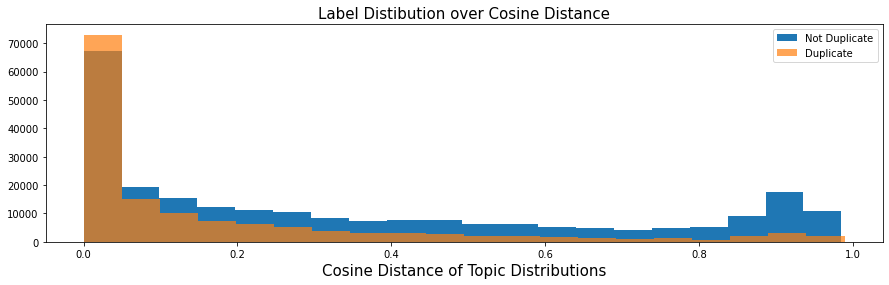

In [323]:
# Label distribution over sent2vec cosine distance
plt.figure(figsize=(15, 4))
plt.hist(df[df['is_duplicate'] == 0].lda_cosine_dist, bins = 20, label = 'Not Duplicate')
plt.hist(df[df['is_duplicate'] == 1].lda_cosine_dist, bins = 20, alpha = 0.7, label = 'Duplicate')
plt.legend()
plt.title('Label Distibution over Cosine Distance', fontsize=15)
plt.xlabel('Cosine Distance of Topic Distributions', fontsize=15)

Now lets look at the topic distribution output.

In [324]:
# View topic distributions for questions
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=df_topic_keywords.T.columns)
df_document_topic['question'] = df_stack['question']
df_document_topic = df_document_topic[['question'] + df_topic_keywords.T.columns.to_list()]

In [325]:
df_document_topic.iloc[0:50]

topic_theme,question,Best Ways/Media Access,Learn/Improve/Language/Programming/Skills,Presedential Election/Trump/Clinton,Life/Relationships/Social Media,Start New/Business/Money/Lose Weight,Beliefs and Opinions,India/Politics/Economy,Buy/Mobile/Website,Human Experience/Appearance,Make Money/Online/Countries,STEM/Study/Prepare/Career
0,What is the step by step guide to invest in share market in india?,0.47,0.01,0.01,0.01,0.01,0.01,0.45,0.01,0.01,0.01,0.01
1,What is the story of Kohinoor (Koh-i-Noor) Diamond?,0.70,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03
2,How can I increase the speed of my internet connection while using a VPN?,0.01,0.01,0.01,0.16,0.01,0.01,0.01,0.74,0.01,0.01,0.01
3,Why am I mentally very lonely? How can I solve it?,0.02,0.02,0.02,0.02,0.27,0.27,0.02,0.02,0.02,0.02,0.27
4,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.87,0.01,0.01
5,Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?,0.01,0.01,0.01,0.01,0.01,0.14,0.01,0.01,0.29,0.48,0.01
6,Should I buy tiago?,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05
7,How can I be a good geologist?,0.55,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
8,When do you use シ instead of し?,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.70,0.03,0.03,0.03
9,Motorola (company): Can I hack my Charter Motorolla DCX3400?,0.02,0.02,0.02,0.02,0.02,0.02,0.24,0.56,0.02,0.02,0.02


In [326]:
# Extract dominant topic and its percentage for each question
q1_dominant_topic = np.argmax(q1_lda_output, axis = 1)
q2_dominant_topic = np.argmax(q2_lda_output, axis = 1)
q1_dominant_topic_pct = np.max(q1_lda_output, axis = 1)
q2_dominant_topic_pct = np.max(q2_lda_output, axis = 1)

In [327]:
# Add columns to df
df['q1_dominant_topic'] =  q1_dominant_topic
df['q2_dominant_topic'] =  q2_dominant_topic
df['q1_dominant_topic_pct'] =  q1_dominant_topic_pct
df['q2_dominant_topic_pct'] =  q2_dominant_topic_pct

df['q1_topic_name'] = df.apply(lambda row: topics_theme[row['q1_dominant_topic']], axis = 1)
df['q2_topic_name'] = df.apply(lambda row: topics_theme[row['q2_dominant_topic']], axis = 1)

In [328]:
df[['question1', 'q1_topic_name', 'question2', 'q2_topic_name', 'is_duplicate']].head()

,question1,q1_topic_name,question2,q2_topic_name,is_duplicate
0,What is the step by step guide to invest in share market in india?,Best Ways/Media Access,What is the step by step guide to invest in share market?,Best Ways/Media Access,0
1,What is the story of Kohinoor (Koh-i-Noor) Diamond?,Best Ways/Media Access,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,Make Money/Online/Countries,0
2,How can I increase the speed of my internet connection while using a VPN?,Buy/Mobile/Website,How can Internet speed be increased by hacking through DNS?,Buy/Mobile/Website,0
3,Why am I mentally very lonely? How can I solve it?,STEM/Study/Prepare/Career,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",Buy/Mobile/Website,0
4,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Human Experience/Appearance,Which fish would survive in salt water?,Human Experience/Appearance,0


In [329]:
df[['question1', 'q1_topic_name', 'q1_dominant_topic_pct', 'question2', 'q2_topic_name', 'q2_dominant_topic_pct', 'is_duplicate']].head()

,question1,q1_topic_name,q1_dominant_topic_pct,question2,q2_topic_name,q2_dominant_topic_pct,is_duplicate
0,What is the step by step guide to invest in share market in india?,Best Ways/Media Access,0.470638,What is the step by step guide to invest in share market?,Best Ways/Media Access,0.566063,0
1,What is the story of Kohinoor (Koh-i-Noor) Diamond?,Best Ways/Media Access,0.696955,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,Make Money/Online/Countries,0.549818,0
2,How can I increase the speed of my internet connection while using a VPN?,Buy/Mobile/Website,0.740329,How can Internet speed be increased by hacking through DNS?,Buy/Mobile/Website,0.474198,0
3,Why am I mentally very lonely? How can I solve it?,STEM/Study/Prepare/Career,0.272727,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",Buy/Mobile/Website,0.584047,0
4,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Human Experience/Appearance,0.870127,Which fish would survive in salt water?,Human Experience/Appearance,0.870127,0


Enter a test question to see how it is labelled.

In [330]:
# ENTER TEST QUESTION HERE
q_test = 'How can I make a successful business selling lemonade?'
q_clean = [clean_qs(q_test)]
tf_test = tf_vectorizer.transform(q_clean)
test_output = models_sk[2].transform(tf_test)
df_test = pd.DataFrame(np.round(test_output,2), columns = df_topic_keywords.T.columns)
df_test['question'] = q_test
df_test[['question'] + df_topic_keywords.T.columns.to_list()]


topic_theme,question,Best Ways/Media Access,Learn/Improve/Language/Programming/Skills,Presedential Election/Trump/Clinton,Life/Relationships/Social Media,Start New/Business/Money/Lose Weight,Beliefs and Opinions,India/Politics/Economy,Buy/Mobile/Website,Human Experience/Appearance,Make Money/Online/Countries,STEM/Study/Prepare/Career
0,How can I make a successful business selling lemonade?,0.02,0.02,0.02,0.02,0.26,0.22,0.02,0.02,0.02,0.37,0.02


### Word2Vec

Now I switch back over to more feature engineering after digressing into topic modelling. I used word2vec to compute vector representation of each word. Use pretrained googlenews-300d embeddings, Standford's GLoVe embeddings, or train own word2vec. Then I convert word embeddings to question embeddings.

In [274]:
# Set up google news word2vec model
EMBEDDING_FILE = 'GoogleNews-vectors-negative300.bin'

word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

Use TF-IDF to get weighted average of words in each question.

In [275]:
# Sent2Vec: compute word vec for each word in sentence, weight by tf-idf, compute average + normalize, return cosine distance

def sent2Vec(row, tfidf1, tfidf2, X1, X2):
    
    sent_vec1 = np.zeros(300)
    sent_vec2 = np.zeros(300)

    # Tokenize sentence
    text1 = str(row['q1_clean']).split()
    text2 = str(row['q2_clean']).split()

    
    # Loop through words in q1, sum weighted vector representations
    if len(text1) > 0:
        for word in text1:
            if word in word2vec_model.vocab and word in tfidf1.vocabulary_:
                word_idx = tfidf1.vocabulary_[word]
                sent_vec1 += word2vec_model.word_vec(word)*X1[row.name, word_idx]
        
        # Take average
        #sent_vec1 /= len(text1)

        # Normalize vector
        sent_vec1 /= np.sqrt((sent_vec1**2).sum())
    
        
    # Loop through words in q2
    if len(text2) > 0:
        for word in text2:
            if word in word2vec_model.vocab and word in tfidf2.vocabulary_:
                word_idx = tfidf2.vocabulary_[word]
                sent_vec2 += word2vec_model.word_vec(word)*X2[row.name, word_idx]  

        # Take average
        #sent_vec2 /= len(text2)

        # Normalize vecotr
        sent_vec2 /= np.sqrt((sent_vec2**2).sum())      
    
        
    # Return cosine distance score
    return np.nan_to_num(cosine(sent_vec1, sent_vec2))


Compute cosine distance between two sentence embeddings

In [276]:
# Get sent2Vec Cosine Distance

def get_fs_3(df, tfidf1, tfidf2, X1, X2):

    # Apply sent2Vec and compute cosine distance
    df['cosine_dist'] = df.apply(sent2Vec, axis = 1, args = (tfidf1, tfidf2, X1, X2))

    return df


In [277]:
# Get cosine distances
df = get_fs_3(df, tfidf_q1, tfidf_q2, Xq1, Xq2)


In [281]:
df['cosine_dist'] = np.round(df['cosine_dist'], 2)

Text(0.5, 0, 'Cosine Distance of Sentence Vectors')

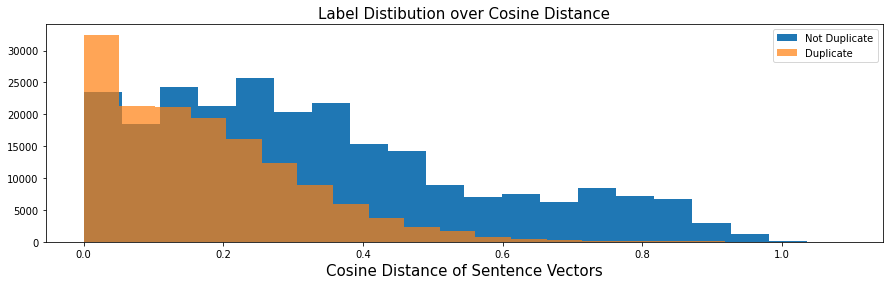

In [282]:
# Label distribution over sent2vec cosine distance
plt.figure(figsize=(15, 4))
plt.hist(df[df['is_duplicate'] == 0].cosine_dist, bins = 20, label = 'Not Duplicate')
plt.hist(df[df['is_duplicate'] == 1].cosine_dist, bins = 20, alpha = 0.7, label = 'Duplicate')
plt.legend()
plt.title('Label Distibution over Cosine Distance', fontsize=15)
plt.xlabel('Cosine Distance of Sentence Vectors', fontsize=15)

Example of non duplicates.

In [283]:
df[['question1', 'question2', 'q1_clean','q2_clean','cosine_dist','is_duplicate']][df.is_duplicate == 0]

,question1,question2,q1_clean,q2_clean,cosine_dist,is_duplicate
0,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,step step guide invest share market india,step step guide invest share market,0.01,0
1,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,story kohinoor koh noor diamond,would happen indian government stole kohinoor koh noor diamond back,0.19,0
2,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,increase speed internet connection using vpn,internet speed increased hacking dns,0.26,0
3,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",mentally lonely solve,find remainder math math divided,0.70,0
4,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,one dissolve water quikly sugar salt methane carbon di oxide,fish would survive salt water,0.42,0
...,...,...,...,...,...,...
388960,What is the minimum time required to build a flyover of about 1km?,What is a cheaper and quicker way to build an underpass or a flyover and why?,minimum time required build flyover,cheaper quicker way build underpass flyover,0.33,0
388964,What do you think of the removal of the MagSafe connector from Apple's 2016 MacBook Pro?,What will the CPU upgrade to the 2016 Apple MacBook Pro mean?,think removal magsafe connector apple macbook pro,cpu upgrade apple macbook pro mean,0.28,0
388966,How many keywords are there in the Racket programming language of the latest version?,How many keywords are there in PERL Programming Language in the latest version?,many keywords racket programming language latest version,many keywords perl programming language latest version,0.24,0
388968,"What is the approx annual cost of living while studying in UIC Chicago, for an Indian student?","I am having little hairfall problem but I want to use hair styling product. Which one should I prefer out of gel, wax and clay?",approx annual cost living studying uic chicago indian student,little hairfall problem want use hair styling product one prefer gel wax clay,0.74,0


Example of duplicates.

In [284]:
df[['question1', 'q1_clean','question2', 'q2_clean','cosine_dist','is_duplicate']][df.is_duplicate == 1]

,question1,q1_clean,question2,q2_clean,cosine_dist,is_duplicate
5,Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?,astrology capricorn sun cap moon cap rising say,"I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?",triple capricorn sun moon ascendant capricorn say,0.46,1
7,How can I be a good geologist?,good geologist,What should I do to be a great geologist?,great geologist,0.02,1
11,How do I read and find my YouTube comments?,read find youtube comments,How can I see all my Youtube comments?,see youtube comments,0.07,1
12,What can make Physics easy to learn?,make physics easy learn,How can you make physics easy to learn?,make physics easy learn,0.00,1
13,What was your first sexual experience like?,first sexual experience like,What was your first sexual experience?,first sexual experience,0.02,1
...,...,...,...,...,...,...
388961,What are some outfit ideas to wear to a frat party?,outfit ideas wear frat party,What are some outfit ideas wear to a frat themed party?,outfit ideas wear frat themed party,0.10,1
388962,Why is Manaphy childish in Pokémon Ranger and the Temple of the Sea?,manaphy childish pok mon ranger temple sea,Why is Manaphy annoying in Pokemon ranger and the temple of the sea?,manaphy annoying pokemon ranger temple sea,0.21,1
388963,How does a long distance relationship work?,long distance relationship work,How are long distance relationships maintained?,long distance relationships maintained,0.19,1
388965,What does Jainism say about homosexuality?,jainism say homosexuality,What does Jainism say about Gays and Homosexuality?,jainism say gays homosexuality,0.11,1


To visualize the Word2Vec embeddings in our corpus, I created a word2vec model trained on our corpus. 

In [285]:
# Create our own word2Vec model for plotting, first build corpus with both questions
def build_corpus(data):
    corpus = []
    for col in ['q1_clean', 'q2_clean']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(df) 

In [286]:
# Word2Vec using corpus
model = gensim.models.Word2Vec(corpus, size=100, window=20, min_count=4500, workers=4)

In [287]:
# TSNE Plots
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(8, 8)) 

    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        plt.xlabel('1st Principal Component')
        plt.ylabel('2nd Principal Component')
        plt.title('TSNE Plot for Common Terms in Corpus')
    plt.show()

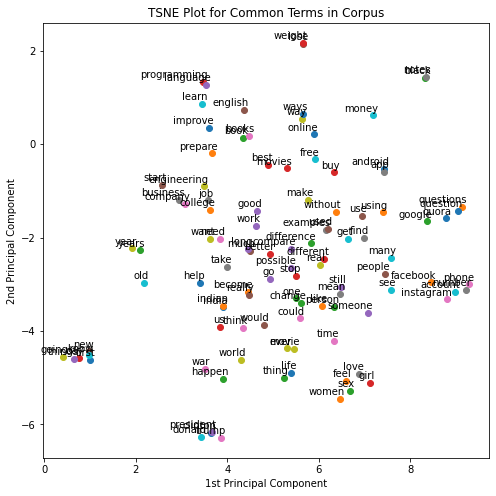

In [288]:
tsne_plot(model)

## Model Implementation
Now that we've compile a set of features, we can use it to predict whether or not the questions are duplicates. We will mix and match different sets of features and implement two different algorithms: logistic regression and XGBoost.

In [27]:
# Check for nans
df.isnull().values.any()

False

Load in full feature set as df

In [95]:
#df.to_csv('final_features.csv')
#df = pd.read_csv('final_features.csv')

Build correlation plot to visualize how well each of our features predict the target.

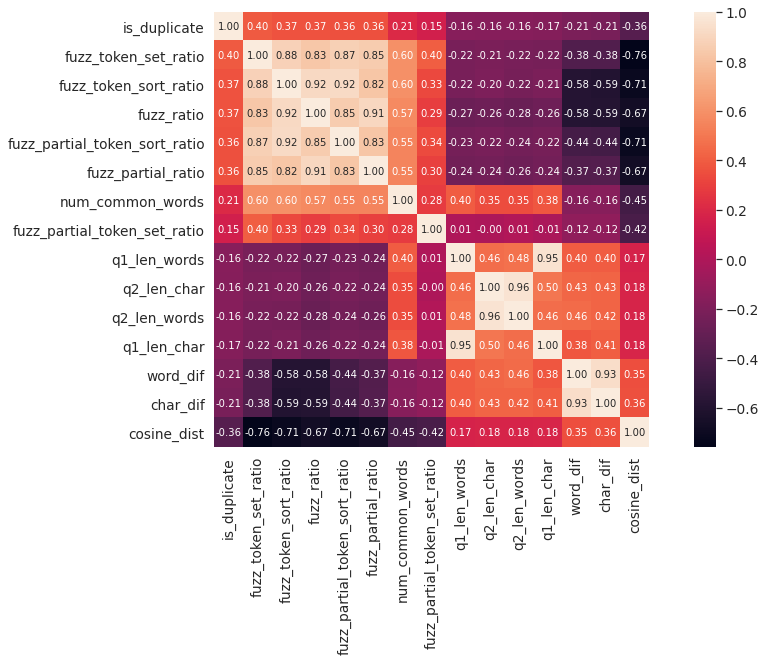

In [97]:
# Feature correlation matrix
X = df.drop(['Unnamed: 0', 'id', 'qid1', 'qid2', 'question1', 'question2', 'q1_clean', 'q2_clean', 'q1_lemma', 'q2_lemma'], axis = 1)

k = 20
plt.figure(figsize=(16,8))
corrmat = X.corr()

# picking the top 15 correlated features
cols = corrmat.nlargest(k, 'is_duplicate')['is_duplicate'].index
cm = np.corrcoef(X[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [291]:
# SELECTING FEATURES
# Here we can mix and match features to determine how they impact the model performance. Since the TFIDF matrix is a massive sparse matrix,
# it can only be used independent of the other features.

# Basic Features
fs_1 = ['q1_len_char', 'q2_len_char', 'q1_len_words', 'q2_len_words', 'num_common_words', 'char_dif', 'word_dif']

# Fuzzy Features
fs_2 = ['fuzz_ratio', 'fuzz_partial_ratio', 'fuzz_token_set_ratio', 'fuzz_token_sort_ratio', 'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio']

# Sent2Vec features
fs_3 = ['cosine_dist']

# True for TFIDF features only
tf_idf_only = True

# True for SVD features only
svd_only = False

# Prepare training data
fs = fs_1 + fs_2 + fs_3

# If we are using TFIDF or SVD features, we need to accomidate sparse matrix format
if tf_idf_only:
    # Stack tf-idf matrices next to each other
    X = sparse.hstack((Xq1, Xq2))
elif svd_only:

    # Stack svd matrices next to each other
    X = np.hstack((X_svd_q1, X_svd_q2))
else:
    X = df[fs]
    


# Set targets
y = df['is_duplicate']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

# Scaling features if not TFIDF or SVD
if not tf_idf_only and not svd_only:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

## Logistic Regression
Implementation of logistic regression. 5-Fold cross validation stratified by the target distribution to find optimal penalization coeffieicient.

In [292]:
# Set up Grid Search to find best hyperparamters
kfold = StratifiedKFold(n_splits = 5)
kfold.get_n_splits(X_train, y_train)

# Initialize best params
best_params = {}
best_logloss = 100
best_std = 0


# Run Grid Search over regularization coefficienct and solver type
for C in [0.01, 0.1, 1., 10.]:
    for solver in ['lbfgs', 'newton-cg']:
        print(C, solver)
        np_idx = 0
        loglosses = np.zeros(5)

        for train_idx, val_idx in kfold.split(X_train, y_train):
            
            if tf_idf_only:
                X_train2, X_val = X_train[train_idx], X_train[val_idx]
            else:
                X_train2, X_val = pd.DataFrame(X_train[train_idx]), pd.DataFrame(X_train[val_idx])

            y_train2, y_val = pd.DataFrame(y_train.values[train_idx]), pd.DataFrame(y_train.values[val_idx])


            lr = LogisticRegression(C = C, solver = solver)
            lr.fit(X_train2, y_train2.values.ravel())
            preds = lr.predict_proba(X_val)
            logloss = log_loss(y_val, preds[:,1])
            print ("Fold {}: Log-loss: {}".format(np_idx, round(logloss, 3)))

            loglosses[np_idx] = logloss             
            np_idx += 1

        if np.mean(loglosses) < best_logloss:
            best_params = {'C': C, 'solver': solver}
            best_logloss = np.mean(loglosses)
            best_std = np.std(loglosses)  


        print ("Overall Log-loss: {} +/- {}".format(round(np.mean(loglosses), 2), round(np.std(loglosses), 2)))


# Fit best model
lr = LogisticRegression(C = best_params['C'], solver = best_params['solver'])
lr.fit(X_train, y_train)

0.01 lbfgs
Fold 0: Log-loss: 0.603
Fold 1: Log-loss: 0.603
Fold 2: Log-loss: 0.603
Fold 3: Log-loss: 0.603
Fold 4: Log-loss: 0.603
Overall Log-loss: 0.6 +/- 0.0
0.01 newton-cg
Fold 0: Log-loss: 0.603
Fold 1: Log-loss: 0.603
Fold 2: Log-loss: 0.603
Fold 3: Log-loss: 0.603
Fold 4: Log-loss: 0.603
Overall Log-loss: 0.6 +/- 0.0
0.1 lbfgs
Fold 0: Log-loss: 0.537
Fold 1: Log-loss: 0.538
Fold 2: Log-loss: 0.539
Fold 3: Log-loss: 0.538
Fold 4: Log-loss: 0.539
Overall Log-loss: 0.54 +/- 0.0
0.1 newton-cg
Fold 0: Log-loss: 0.537
Fold 1: Log-loss: 0.538
Fold 2: Log-loss: 0.539
Fold 3: Log-loss: 0.538
Fold 4: Log-loss: 0.539
Overall Log-loss: 0.54 +/- 0.0
1.0 lbfgs
Fold 0: Log-loss: 0.483
Fold 1: Log-loss: 0.484
Fold 2: Log-loss: 0.485
Fold 3: Log-loss: 0.485
Fold 4: Log-loss: 0.486
Overall Log-loss: 0.48 +/- 0.0
1.0 newton-cg
Fold 0: Log-loss: 0.483
Fold 1: Log-loss: 0.484
Fold 2: Log-loss: 0.485
Fold 3: Log-loss: 0.485
Fold 4: Log-loss: 0.486
Overall Log-loss: 0.48 +/- 0.0
10.0 lbfgs
Fold 0: Log

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [293]:
# Fit best model
lr = LogisticRegression(C = best_params['C'], solver = best_params['solver'])
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [294]:
# Test Scores
print('Log Loss: {}'.format(round(log_loss(y_test, lr.predict_proba(X_test)[:,1]), 2)))
print('Accuracy: {}'.format(round(accuracy_score(y_test, lr.predict(X_test)), 2)))

Log Loss: 0.48
Accuracy: 0.78


In [295]:
roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])

0.8318196615474078

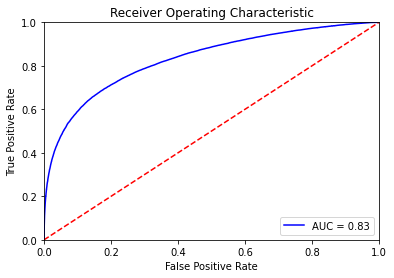

In [296]:
# Generate ROC curve for test data

def get_roc_curve(preds):

    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Test predictions
probs = lr.predict_proba(X_test)
preds = probs[:,1]

# Get ROC Curve
get_roc_curve(preds)

In [314]:
all_preds = lr.predict_proba(X)[:,1]
df['lr_preds'] = np.round(all_preds, 2)
df['lr_pred_class'] = np.round(all_preds, 0).astype(int)



In [354]:
df[['question1', 'question2', 'is_duplicate', 'lr_preds', 'lr_pred_class']].head(20)

,question1,question2,is_duplicate,lr_preds,lr_pred_class
0,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0,0.20,0
1,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0,0.16,0
2,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0,0.18,0
3,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0,0.12,0
4,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0,0.23,0
5,Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?,"I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?",1,0.36,0
6,Should I buy tiago?,What keeps childern active and far from phone and video games?,0,0.19,0
7,How can I be a good geologist?,What should I do to be a great geologist?,1,0.36,0
8,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,0.08,0
9,Motorola (company): Can I hack my Charter Motorolla DCX3400?,How do I hack Motorola DCX3400 for free internet?,0,0.39,0


In [308]:
df[(df['lr_preds'] < 0.1) & (df['is_duplicate'] == 1)][['question1', 'q1_clean', 'q2_clean', 'question2', 'is_duplicate', 'lr_preds']]

,question1,q1_clean,q2_clean,question2,is_duplicate,lr_preds
50,"Will a Blu Ray play on a regular DVD player? If so, how?",blu ray play regular dvd player,play blu ray dvd regular dvd player,How can you play a Blu Ray DVD on a regular DVD player?,1,0.07
149,Why does Red keep the keys in OITNB?,red keep keys oitnb,red keep keys season orange new black,Why does Red keep the keys in season 4 of Orange is the New Black?,1,0.06
1164,What are the minimum GPA and GRE requirements of Florida State University?,minimum gpa gre requirements florida state university,minimum gpa gre requirements florida state university,What are the minimum GPA and GRE requirements of Florida State University?,1,0.09
1264,I m bio student how I got admission in vits Vellore in biotechnology and I don't have math in 12?,bio student got admission vits vellore biotechnology math,kindly tell whole process admission vits vellore biotech bio student math,Kindly tell me whole process of admission at vits Vellore for biotech.i m a bio student in 12..I don't have math there?,1,0.05
2041,What are the most beautiful French songs?,beautiful french songs,good french songs,What are some good French songs?,1,0.09
...,...,...,...,...,...,...
387253,How do I unlock a Samsung Galaxy Y Duos (GT-S6102) phone once it gets locked due to multiple unlocking attempts?,unlock samsung galaxy duos gt phone gets locked due multiple unlocking attempts,unlock samsung galaxy duos gt phone screen lock,How do I unlock a Samsung Galaxy Y Duos (GT-S6102) phone screen lock?,1,0.07
387829,Should I remove my wisdom teeth?,remove wisdom teeth,wisdom tooth removed,Should I have my wisdom tooth removed?,1,0.09
388349,What are the alternatives to Skype for Samsung smart TVs?,alternatives skype samsung smart tvs,alternative skype samsung smart tv skype cam skype discontinued skype tv camera would useless,"What can be an alternative to Skype on the Samsung Smart TV which has a Skype Cam? As Skype has discontinued Skype TV, the camera would be useless!",1,0.03
388379,Why there is d in fridge and not in refrigerator?,fridge refrigerator,word fridge word refrigerator,Why is there a 'd' in the word fridge but not in the word refrigerator?,1,0.06


In [303]:
df[(df['lr_preds'] < 0.1) & (df['is_duplicate'] == 0)][['question1', 'question2', 'is_duplicate', 'lr_preds']]

,question1,question2,is_duplicate,lr_preds
8,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,0.08
14,"What are the laws to change your status from a student visa to a green card in the US, how do they compare to the immigration laws in Canada?",What are the laws to change your status from a student visa to a green card in the US? How do they compare to the immigration laws in Japan?,0,0.07
25,What are some tips on making it through the job interview process at Medicines?,What are some tips on making it through the job interview process at Foundation Medicine?,0,0.02
33,"Does the United States government still blacklist (employment, etc.) some United States citizens because their political views?",How is the average speed of gas molecules determined?,0,0.08
40,When can I expect my Cognizant confirmation mail?,When can I expect Cognizant confirmation mail?,0,0.07
...,...,...,...,...
388922,"How do you know if a molecule has a single, double, or triple bond?","Is an atom a solid , liquid or gas ? Or is it none ?",0,0.09
388934,"What does it mean when FaceTime says someone is ""not available"" for FaceTime?",Why can my mom see my FaceTime history?,0,0.09
388947,Is it safe to store an external battery power bank (for USB devices) in a car?,How do I make a safe and cheap power bank?,0,0.04
388966,How many keywords are there in the Racket programming language of the latest version?,How many keywords are there in PERL Programming Language in the latest version?,0,0.04


In [306]:
df[(df['lr_preds'] > 0.9) & (df['is_duplicate'] == 1)][['question1', 'question2', 'is_duplicate', 'lr_preds']]

,question1,question2,is_duplicate,lr_preds
18,Why are so many Quora users posting questions that are readily answered on Google?,Why do people ask Quora questions which can be answered easily by Google?,1,0.92
71,How I can speak English fluently?,How can I learn to speak English fluently?,1,0.95
78,What is purpose of life?,What's the purpose of life? What is life actually about?,1,0.94
85,"What were the major effects of the cambodia earthquake, and how do these effects compare to the Kamchatca earthquakes in 1952?","What were the major effects of the cambodia earthquake, and how do these effects compare to the Valparaiso earthquake in 1822?",1,0.97
87,Which is the best gaming laptop under 60k INR?,Which is the best gaming laptop under Rs 60000?,1,0.93
...,...,...,...,...
388842,What made Tata group chairman Cyrus Mistry to quit?,Why Cyrus Mistry has been removed from Tata Group?,1,0.93
388844,Is Donald Trump really a Democrat?,Is it possible that Donald Trump is in cahoots with Hillary Clinton?,1,0.91
388882,How do we time travel?,Is time travel theoretically possible?,1,0.95
388901,What are your new year resolutions for 2017?,What will be your new year resolution for 2017 and your plan of execution?,1,0.94


In [307]:
df[(df['lr_preds'] > 0.9) & (df['is_duplicate'] == 0)][['question1', 'question2', 'is_duplicate', 'lr_preds']]

,question1,question2,is_duplicate,lr_preds
28,What is best way to make money online?,What is best way to ask for money online?,0,0.95
481,What will most likely cause World War III?,Is World War III imminent?,0,0.91
1295,What do you think of the decision by the Indian Government to demonetize 500 and 1000 rupee notes?,Is the Indian government's decision to illegalise 500 and 1000 rupee notes a masterstroke or a flawed plan?,0,0.93
3952,What are the safety precautions on handling shotguns proposed by the NRA in Iowa?,"What are the safety precautions on handling shotguns proposed by the NRA in Alabama and every other state, territory and possession in the U.S.?",0,0.94
3957,Why is the Indian government not abolishing the currency note of 500 and 1000 to reduce black money?,What is the percentage of domestic black money in the Indian black money and how much will Indians benefit after banning of 500 and 1000 rupees notes?,0,0.91
...,...,...,...,...
386199,What do you think about the new 500 and 2000 rupee notes?,What should everyone know about the 500-rupee and 2000-rupee notes?,0,0.99
387561,What are some good was to earn money online?,What are the best websites to earn money online?,0,0.92
387606,Why do we lose weight?,Why can't I lose weight?,0,0.92
387646,What are the best ways to lose weight?,How can you lose 5 pounds in 2 weeks safely?,0,0.96


Text(0.5, 0, 'Predicted Duplicate Probability')

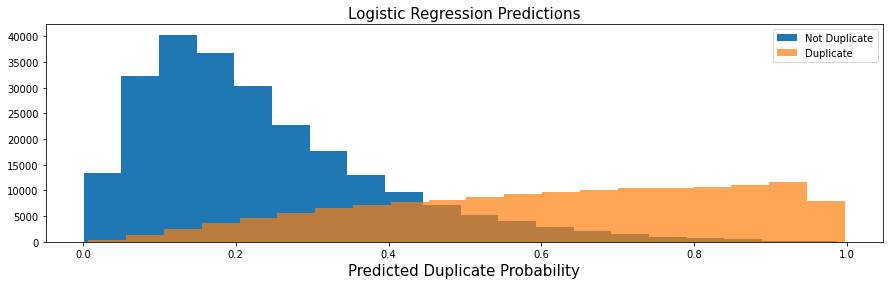

In [300]:
# Label distribution over predicted probabilities
plt.figure(figsize=(15, 4))
plt.hist(df[df['is_duplicate'] == 0].lr_preds, bins = 20, label = 'Not Duplicate')
plt.hist(df[df['is_duplicate'] == 1].lr_preds, bins = 20, alpha = 0.7, label = 'Duplicate')
plt.legend()
plt.title('Logistic Regression Predictions', fontsize=15)
plt.xlabel('Predicted Duplicate Probability', fontsize=15)

Duplicate prediction performance by topic

## XGBoost

Implementation of XGBoost algorithm.

In [18]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label = y_train)

watchlist = [(d_train, 'train')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.688183
Will train until train-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.646449
[20]	train-logloss:0.61688
[30]	train-logloss:0.5946
[40]	train-logloss:0.577793
[50]	train-logloss:0.564793
[60]	train-logloss:0.554623
[70]	train-logloss:0.54623
[80]	train-logloss:0.539534
[90]	train-logloss:0.534438
[100]	train-logloss:0.530064
[110]	train-logloss:0.52644
[120]	train-logloss:0.523202
[130]	train-logloss:0.520561
[140]	train-logloss:0.518398
[150]	train-logloss:0.516659
[160]	train-logloss:0.515254
[170]	train-logloss:0.513872
[180]	train-logloss:0.513058
[190]	train-logloss:0.512575
[200]	train-logloss:0.512109
[210]	train-logloss:0.511639
[220]	train-logloss:0.511092
[230]	train-logloss:0.511085
[240]	train-logloss:0.511091
[250]	train-logloss:0.511093
[260]	train-logloss:0.511091
[270]	train-logloss:0.511082
[280]	train-logloss:0.511089
[290]	train-logloss:0.511087
[300]	train-logloss:0.511085
Stopping. Best iteration:
[257]	train-logloss:0.511077



Log Loss: 0.51
Accuracy: 0.71


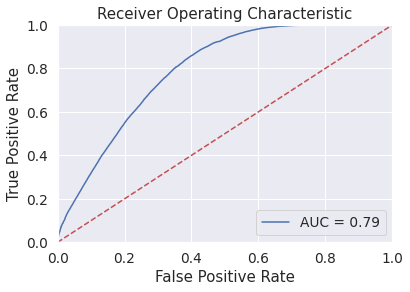

In [19]:
# Test metrics
d_test = xgb.DMatrix(X_test)
p_test = bst.predict(d_test)

# Test Scores
print('Log Loss: {}'.format(round(log_loss(y_test, p_test), 2)))
print('Accuracy: {}'.format(round(accuracy_score(y_test, np.round(p_test)), 2)))

# Get ROC curve
get_roc_curve(p_test)

## Saving Model and Registering

Save models if desired

In [20]:
#joblib.dump(lr, 'quora_duplicates_lr_v2.pkl')
#joblib.dump(bst, 'quora_duplicates_xg.pkl')

['quora_duplicates_xg.pkl']